## Lid Driven and free slip boundary conditions in annulus geometry

Very raw model of a annulus geometry in Underworld.

How? A 2D rectangular finite element mesh is build with periodic boundary conditions on the short edges. The rectangel is then deformed into a annulus. The velocity DOFs on the boundary (inner and outer) surfaces to be prescribed by DirichletBCs in normal and tangential components ; the rest of the velocity DOFs remains in standard cartesian coordinates.

This implementation uses elemental rotation matrices in the stiffess matrix and force vector construction to orient the DOF to be aligned, ie normal and tangential, to the boundary of the domain. Currently these rotations are only applied to the boundary DOF. 
Consequently the velocity solution immediately after the stokes solve is a mix of boundary condition aligned to normal & tangent direction, while all other (internal) DOF are prescribed in standard cartesian components. A re-rotation must take place.

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math
import numpy

In [2]:
# Set simulation box size.
boxHeight = 1.0
boxLength = 2.0
# Set the resolution.
res = 2
# Set min/max temperatures.
tempMin = 0.0
tempMax = 1.0

# build annulus mesh - handles deforming a recangular mesh and applying periodic dofs
mesh                = uw.mesh._FeMesh_Annulus(elementRes=(10,60), radialLengths=(3,6))

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
tField              = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
vmag = fn.math.sqrt(fn.math.dot( velocityField, velocityField ))

In [3]:
# build copy of velocity MeshVariable - will hold there-ratation vector
vcopy = velocityField.copy()
vcpEqNum = uw.systems.sle.EqNumber( vcopy, False )
ans = uw.systems.sle.SolutionVector(vcopy, vcpEqNum)

In [4]:
# TODO: clean up - is important to flag rotation matrix operations are required
velocityField._cself.nonAABCs = 1

In [5]:
# Set viscosity to be a constant.
viscosity = 1.
buoyancyFn = (0.,0.0)

In [6]:
lower = mesh.specialSets["MinI_VertexSet"]
upper = mesh.specialSets["MaxI_VertexSet"]
east = mesh.specialSets["MinJ_VertexSet"]
west = mesh.specialSets["MaxJ_VertexSet"]
drivers = upper
# vx -> vn (normal)
# vy -> vt (tangential)
velocityField.data[ drivers.data ] = [0.0,6.0]
velBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                          indexSetsPerDof = (lower+upper, upper) )



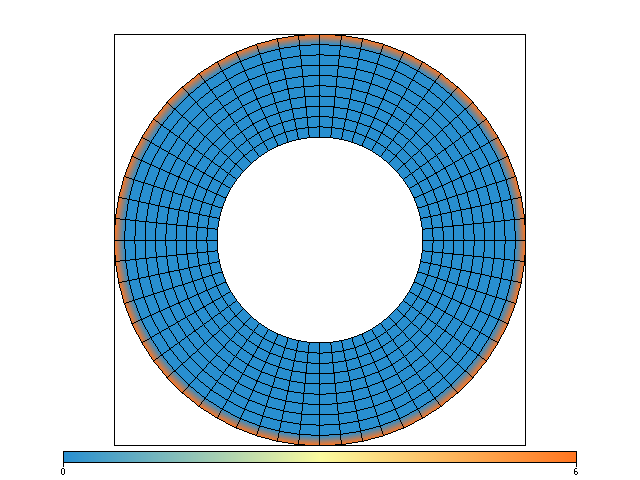

In [7]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Mesh( mesh ))
# fig.append(glucifer.objects.VectorArrows(mesh, velocityField ))
fig.append(glucifer.objects.Surface(mesh, vmag, onMesh=True  ))
fig.show()

In [8]:
stokesSLE = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = velBC,
                            fn_viscosity  = viscosity, 
                            fn_bodyforce  = buoyancyFn,
                            _removeBCs    = False)      # _removeBC is required
solver = uw.systems.Solver( stokesSLE )

In [9]:
# build re-rotate matrix to applied globally 
rot = uw.systems.sle.AssembledMatrix( ans, ans, rhs=None )

gaussSwarm = stokesSLE._constitMatTerm._integrationSwarm

rot._cself.assembleOnNodes = 1 # still important
term = uw.systems.sle.MatrixAssemblyTerm_RotationDof(integrationSwarm=gaussSwarm,
                                                     assembledObject = rot,
                                                     fn_e1=mesh.rot_vec_normal,
                                                     fn_e2=mesh.rot_vec_tangent,
                                                     mesh=mesh)


uw.libUnderworld.StgFEM.StiffnessMatrix_Assemble( 
    rot._cself, 
    None, None );

In [10]:
# add rotation matrix using the following
uw.libUnderworld.StgFEM.StiffnessMatrix_SetRotationTerm(stokesSLE._kmatrix._cself, term._cself)
uw.libUnderworld.StgFEM.StiffnessMatrix_SetRotationTerm(stokesSLE._gmatrix._cself, term._cself)
uw.libUnderworld.StgFEM.ForceVector_SetRotationTerm(stokesSLE._fvector._cself, term._cself)

In [11]:
solver.solve() # results in velocity solution being mixed

In [12]:
# re-rotate and unmix
uw.libUnderworld.Underworld.AXequalsY( rot._cself, stokesSLE._velocitySol._cself, ans._cself, False)

In [13]:
fig = glucifer.Figure()
# fig.append( glucifer.objects.Mesh( mesh ))
fig.append(glucifer.objects.VectorArrows(mesh, velocityField/5., onMesh=True ))
fig.append(glucifer.objects.Surface(mesh, vmag, onMesh=True  ))
# fig.show()

In [14]:
# create checkpoint function
def checkpoint( mesh, fieldDict, swarm, swarmDict, index,
                meshName='mesh', swarmName='swarm', 
                prefix='./', enable_xdmf=True):
    import os
    # Check the prefix is valid
    if prefix is not None:
        if not prefix.endswith('/'): prefix += '/' # add a backslash
        if not os.path.exists(prefix) and uw.rank()==0:
            print "Creating directory: ",prefix 
            os.makedirs(prefix)
        uw.barrier() 
            
    if not isinstance(index, int):
        raise TypeError("'index' is not of type int")        
    ii = str(index)
    
    if mesh is not None:
        
        # Error check the mesh and fields
        if not isinstance(mesh, uw.mesh.FeMesh):
            raise TypeError("'mesh' is not of type uw.mesh.FeMesh")
        if not isinstance(fieldDict, dict):
            raise TypeError("'fieldDict' is not of type dict")
        for key, value in fieldDict.iteritems():
            if not isinstance( value, uw.mesh.MeshVariable ):
                raise TypeError("'fieldDict' must contain uw.mesh.MeshVariable elements")


        # see if we have already saved the mesh. It only needs to be saved once
        if not hasattr( checkpoint, 'mH' ):
            checkpoint.mH = mesh.save(prefix+meshName+".h5")
        mh = checkpoint.mH

        for key,value in fieldDict.iteritems():
            filename = prefix+key+'-'+ii
            handle = value.save(filename+'.h5')
            if enable_xdmf: value.xdmf(filename, handle, key, mh, meshName)
        
    # is there a swarm
    if swarm is not None:
        
        # Error check the swarms
        if not isinstance(swarm, uw.swarm.Swarm):
            raise TypeError("'swarm' is not of type uw.swarm.Swarm")
        if not isinstance(swarmDict, dict):
            raise TypeError("'swarmDict' is not of type dict")
        for key, value in swarmDict.iteritems():
            if not isinstance( value, uw.swarm.SwarmVariable ):
                raise TypeError("'fieldDict' must contain uw.swarm.SwarmVariable elements")
    
        sH = swarm.save(prefix+swarmName+"-"+ii+".h5")
        for key,value in swarmDict.iteritems():
            filename = prefix+key+'-'+ii
            handle = value.save(filename+'.h5')
            if enable_xdmf: value.xdmf(filename, handle, key, sH, swarmName)


In [15]:
# xdmf output
fieldDict = {'mixedVel':velocityField, # mixed
             'finalVec':vcopy}         # re-rotated
checkpoint(mesh, fieldDict, None, None, index=0, prefix='output')